In [21]:
import os
import json
import time
import random
import numpy as np
import pandas as pd
import openml
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import qiskit
from qiskit import QuantumCircuit
from qiskit.circuit.library import TwoLocal, ZZFeatureMap
from qiskit.primitives import StatevectorSampler, Sampler
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.gradients import ParamShiftSamplerGradient, SPSASamplerGradient
from qiskit.transpiler import PassManager

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

In [22]:
def set_seed(seed):
    """Set the random seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Data

In [23]:
def get_data(openml_dataset_id):
    try:
        dataset = openml.datasets.get_dataset(openml_dataset_id)
        print(f"Dataset name: {dataset.name}")
    except Exception as e:
        print(f"Error fetching dataset {openml_dataset_id}: {e}")
        return None
    X, y, _, _ = dataset.get_data(target=dataset.default_target_attribute)
    X = pd.get_dummies(X)
    le = LabelEncoder()
    y = le.fit_transform(y)
    return X, y, le

def process_data(X, y):
    """Clean data: drop NaNs, duplicates, constant columns, and remove categoricals.
    Assumes X is DataFrame, y is ndarray."""
    y = pd.Series(y, index=X.index)

    total_features = X.shape[1]
    num_categoricals = X.select_dtypes(exclude=["number"]).shape[1]

    X = X.dropna()
    y = y.loc[X.index]

    X = X.drop_duplicates()
    y = y.loc[X.index]

    X = X.select_dtypes(include=["number"]) # dropping categorical features currently

    remaining_features = X.shape[1]

    print(f"Total features: {total_features}, Dropped Categorical features: {num_categoricals}, Remaining features: {remaining_features}")

    return pd.DataFrame(X), y.to_numpy()


def scale_data_classical(x_train, x_val, x_test):
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_val = scaler.transform(x_val)
    x_test = scaler.transform(x_test)

    return x_train, x_val, x_test

def scale_data_quantum(x_train, x_val, x_test):
    # scaler = MinMaxScaler() # MinMaxScaler(feature_range=(0, np.pi))
    scaler = MinMaxScaler()
    x_train = scaler.fit_transform(x_train)
    x_val = scaler.transform(x_val)
    x_test = scaler.transform(x_test)
    return x_train, x_val, x_test

def apply_pca(X, n_components=2, seed=42):
    pca = PCA(n_components=n_components, random_state=seed)
    X_pca = pca.fit_transform(X)
    return X_pca

def create_data_splits(X, y, batch_size=32, is_classical=True, do_pca=False, n_components=2, seed=42):

    is_multiclass = len(np.unique(y)) > 2

    if do_pca:
        X = apply_pca(X, n_components=n_components, seed=seed)
        print(f"{'Classical' if is_classical else 'Quantum'} data reduced to {X.shape[1]} dimensions using PCA.")

    x_train, x_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=seed, stratify=y) # 60/20/20
    x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=seed, stratify=y_temp)

    if is_classical:
        x_train, x_val, x_test = scale_data_classical(x_train, x_val, x_test)
    else:
        x_train, x_val, x_test = scale_data_quantum(x_train, x_val, x_test)

    x_train = torch.tensor(x_train, dtype=torch.float32)
    x_val = torch.tensor(x_val, dtype=torch.float32)
    x_test = torch.tensor(x_test, dtype=torch.float32)

    y_train = torch.tensor(y_train, dtype=torch.long)
    y_val = torch.tensor(y_val, dtype=torch.long)
    y_test = torch.tensor(y_test, dtype=torch.long)

    train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(x_val, y_val), batch_size=batch_size)
    test_loader = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size)

    input_dim = x_train.shape[1]
    output_dim = len(np.unique(y))

    return x_train, x_val, x_test, y_train, y_val, y_test, train_loader, val_loader, test_loader, input_dim, output_dim, is_multiclass

In [24]:
def data_pipeline(openml_dataset_id, batch_size=32, do_pca=False, n_components=2, seed=42):
    X, y, le = get_data(openml_dataset_id)
    if X is None:
        raise ValueError("Failed to fetch data. Exiting.")

    X, y = process_data(X, y)

    # --- Classical ---
    (
        x_train_c,
        x_val_c,
        x_test_c,
        y_train_c,
        y_val_c,
        y_test_c,
        train_loader_c,
        val_loader_c,
        test_loader_c,
        input_dim,
        output_dim,
        is_multiclass,
    ) = create_data_splits(X, y, batch_size=batch_size, is_classical=True, do_pca=do_pca, n_components=n_components, seed=seed)

    # --- Quantum ---
    (
        x_train_q,
        x_val_q,
        x_test_q,
        y_train_q,
        y_val_q,
        y_test_q,
        train_loader_q,
        val_loader_q,
        test_loader_q,
        _,
        _,
        _,
    ) = create_data_splits(X, y, batch_size=batch_size, is_classical=False, do_pca=do_pca, n_components=n_components, seed=seed)
    classical_data = (
        x_train_c,
        x_val_c,
        x_test_c,
        y_train_c,
        y_val_c,
        y_test_c,
        train_loader_c,
        val_loader_c,
        test_loader_c,
    )
    quantum_data = (
        x_train_q,
        x_val_q,
        x_test_q,
        y_train_q,
        y_val_q,
        y_test_q,
        train_loader_q,
        val_loader_q,
        test_loader_q,
    )
    return classical_data, quantum_data, input_dim, output_dim, is_multiclass


In [25]:
def print_class_distribution(y_tensor, name):
    values, counts = torch.unique(y_tensor, return_counts=True)
    total = counts.sum().item()
    print(f"{name} class distribution:")
    for v, c in zip(values.tolist(), counts.tolist()):
        pct = 100 * c / total
        print(f"  Class {v}: {c} samples ({pct:.2f}%)")
    print()


In [26]:
def plot_classification_results(X, y_true, y_pred, 
                                cmap_name="tab10",
                                point_size=60,
                                mistake_size=200,
                                mistake_edgecolor="r"):
    """
    X         : array_like, shape (N,2) — 2D inputs
    y_true    : array_like, shape (N,)  — integer labels 0..(n_classes–1)
    y_pred    : array_like, shape (N,)  — integer labels 0..(n_classes–1)
    cmap_name : matplotlib colormap name for up to 10 classes (e.g. 'tab10','tab20')
    """
    X = np.asarray(X)
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    assert X.shape[0] == y_true.shape[0] == y_pred.shape[0]
    n_classes = len(np.unique(y_true))

    # discrete colormap with exactly n_classes entries
    cmap = plt.get_cmap(cmap_name, n_classes)

    fig, ax = plt.subplots(figsize=(6,6))
    # plot all points, color by true label
    sc = ax.scatter(X[:,0], X[:,1],
                    c=y_true,
                    cmap=cmap,
                    s=point_size,
                    edgecolors="k",
                    alpha=0.8)

    # highlight mistakes
    mask = (y_true != y_pred)
    if mask.any():
        ax.scatter(X[mask,0], X[mask,1],
                   s=mistake_size,
                   facecolors="none",
                   edgecolors=mistake_edgecolor,
                   linewidths=2,
                   label="misclassified")

    # optional legend / colorbar
    if n_classes <= 10:
        # show discrete legend
        handles, _ = sc.legend_elements(prop="colors")
        labels = list(range(n_classes))
        ax.legend(handles, labels, title="class")
    else:
        # fallback to continuous colorbar
        plt.colorbar(sc, ticks=range(n_classes), label="true class")

    ax.set_xlabel("x₀")
    ax.set_ylabel("x₁")
    ax.set_title(f"{n_classes}-class scatter (red holes = mistakes)")
    plt.show()




In [27]:
def results_exporter(model: nn.Module,
                     seed: int = 42,
                     model_type: str = "quantum",
                     ansatz: str = None,
                     dataset_name: str = "iris",
                     batch_size: int = 32,
                     epochs: int = 10,
                     average_time_per_epoch: float = 0.0,
                     input_dim: int = 4, 
                     depth: int = 0,
                     num_classes: int = 3,
                     test_metrics: dict = None,
                     circuit_fp: str = None,
                     params_fp: str = None,
                     save_csv: str = "./results/baseline_results.csv"):

    if os.path.exists(save_csv):
        results_df = pd.read_csv(save_csv)
    else:
        results_df = pd.DataFrame(columns=[
            'datetime', 'seed', 'model_type', 'dataset_name', 'ansatz', 'batch_size', 'epochs',
            'average_time_per_epoch', 'input_dim', 'depth', 'num_classes',
            'train_acc', 'val_acc', 'test_acc', 'test_loss', 'train_losses', 'val_losses',
            'circuit_fp', 'params_fp'
        ])
        results_df.to_csv(save_csv, index=False)
        return False
    
    match_idx = results_df[
        (results_df['model_type'] == model_type) &
        (results_df['dataset_name'] == dataset_name) &
        (results_df['batch_size'] == batch_size) &
        (results_df['epochs'] == epochs) &
        (results_df['input_dim'] == input_dim) &
        (results_df['depth'] == depth) &
        (results_df['num_classes'] == num_classes)
    ].index

    train_losses = json.dumps([round(loss, 4) for loss in model.history.get('train_loss', [])])
    val_losses = json.dumps([round(loss, 4) for loss in model.history.get('val_loss', [])])

    new_row = {
        'datetime': pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S"),
        'seed': seed,
        'model_type': model_type,
        'ansatz': ansatz if ansatz else None,
        'dataset_name': dataset_name,
        'batch_size': batch_size,
        'epochs': epochs,
        'average_time_per_epoch': round(average_time_per_epoch, 4),
        'input_dim': input_dim,
        'depth': depth if model_type == "quantum" else 0,
        'num_classes': num_classes,
        'train_acc': round(model.history['train_acc'][-1], 4) if hasattr(model, 'history') else None,
        'train_losses': train_losses,
        'val_acc': round(model.history['val_acc'][-1], 4) if hasattr(model, 'history') else None,
        'val_losses': val_losses,
        'test_acc': round(test_metrics['test_acc'], 4) if test_metrics else None,
        'test_loss': round(test_metrics['test_loss'], 4) if test_metrics else None,
        'circuit_fp': circuit_fp if circuit_fp else None,
        'params_fp': params_fp if params_fp else None
    }

    # Overwrite or append
    if len(match_idx) > 0:
        results_df.loc[match_idx[0]] = new_row
    else:
        new_row_df = pd.DataFrame([new_row])
        results_df = pd.concat([results_df, new_row_df], ignore_index=True)

    # Save
    results_df.to_csv(save_csv, index=False)
    return True



# Main

## Baselines

In [28]:
# datasets        = ["diabetes"] # ["iris", "wine", "diabetes"]
# pca_components  = [2, 4]
# batch_size      = 32
# epochs          = 100
# openml_ids      = {"diabetes": 37} # {"iris": 61, "wine": 187, "diabetes": 37}
# quantum_depths  = [1, 2, 4]   # try different ansatz depths

# for dataset_name in datasets:
#     openml_id = openml_ids[dataset_name]
#     for n_components in pca_components:
#         print(f"\n** Config: {dataset_name}, PCA={n_components} **")

#         # load data once per config
#         classical_data, quantum_data, input_dim, output_dim, is_multiclass = \
#             data_pipeline(openml_id,
#                           batch_size=batch_size,
#                           do_pca=True,
#                           n_components=n_components)

#         # unpack
#         x_train_c, x_val_c, x_test_c, y_train_c, y_val_c, y_test_c, train_loader_c, val_loader_c, test_loader_c = classical_data
#         x_train_q, x_val_q, x_test_q, y_train_q, y_val_q, y_test_q, train_loader_q, val_loader_q, test_loader_q = quantum_data

#         # classical run (depth not relevant)
#         model_c = ClassicalNN(input_dim, hidden_dim=32, output_dim=output_dim, is_multiclass=is_multiclass)
#         optimizer_c = optim.Adam(model_c.parameters(), lr=0.05)
#         scheduler_c = torch.optim.lr_scheduler.ReduceLROnPlateau(
#             optimizer_c, mode="min", factor=0.3, patience=epochs//5, min_lr=1e-4, verbose=False
#         )
#         start = time.time()
#         model_c.fit(train_loader_c, val_loader_c, epochs=epochs, optimizer=optimizer_c, scheduler=scheduler_c, verbose=False)
#         avg_time = (time.time() - start) / epochs
#         test_c = model_c.evaluate(test_loader_c)
#         print(f"[Classical] Acc={test_c[1]:.4f}, Loss={test_c[0]:.4f}")

#         results_exporter(
#             model_c,
#             model_type="classical",
#             dataset_name=dataset_name,
#             batch_size=batch_size,
#             epochs=epochs,
#             average_time_per_epoch=avg_time,
#             input_dim=input_dim,
#             depth=0,
#             num_classes=output_dim,
#             test_metrics={"test_acc": test_c[1], "test_loss": test_c[0]}
#         )

#         # quantum runs (varying depth)
#         for depth in quantum_depths:
#             model_q = SamplerQNNTorchModel(n_qubits=input_dim, depth=depth, num_classes=output_dim)
#             optimizer_q = optim.Adam(model_q.parameters(), lr=0.05)
#             scheduler_q = torch.optim.lr_scheduler.ReduceLROnPlateau(
#                 optimizer_q, mode="min", factor=0.3, patience=epochs//5, min_lr=1e-4, verbose=False
#             )
#             start_time = time.time()
#             model_q.fit(train_loader_q, val_loader_q, epochs=epochs, optimizer=optimizer_q, scheduler=scheduler_q, verbose=False)
#             avg_time = (time.time() - start) / epochs
#             test_q = model_q.evaluate(test_loader_q)
#             print(f"[Quantum d={depth}] Acc={test_q[1]:.4f}, Loss={test_q[0]:.4f}")

#             results_exporter(
#                 model_q,
#                 model_type="quantum",
#                 dataset_name=dataset_name,
#                 batch_size=batch_size,
#                 epochs=epochs,
#                 average_time_per_epoch=avg_time,
#                 input_dim=input_dim,
#                 depth=depth,
#                 num_classes=output_dim,
#                 test_metrics={"test_acc": test_q[1], "test_loss": test_q[0]}
#             )


## Weight Extraction

In [29]:
from utils.nn.ClassicalNN import ClassicalNN
from utils.nn.QuantumNN import QuantumNN

import utils.ansatze.AnsatzExtractor as AnsatzExtractor

from utils.ansatze.HEA import HEA
from utils.ansatze.RealAmplitudes import RealAmplitudeAnsatz
from utils.ansatze.RandomPQC import RandomPQCAnsatz
from utils.ansatze.MPS import MPSAnsatz
from utils.ansatze.TTN import TTNAnsatz
from utils.ansatze.WIPQC import WeightInformedPQCAnsatz

In [ ]:
# --- Experiment Configurations ---
SEEDS = [0, 1] #, 2, 3, 4]  # For reproducibility

DATASET_NAMES = ["iris", "wine", "diabetes"]  # "diabetes" # Add or modify as needed
OPENML_DATASET_IDS = {
    "iris": 61,
    "wine": 187,
    "diabetes": 37,
}

# Common training parameters
DO_PCA = True
N_COMPONENTS = [2, 4]  # Used if DO_PCA is True
BATCH_SIZE = 32
EPOCHS_CLASSICAL = 100  # Reduced for quick testing; use your value e.g., 100
EPOCHS_QUANTUM = 30  # Reduced for quick testing; use your value e.g., 50
CLASSICAL_LR = 0.01
QUANTUM_LR = 0.05
RESULTS_CSV_FILE = "./results/wi_experiment.csv"
SCHEMA_OUTPUT_DIR = "./results/schemas"  # Directory for saving schemas

# Ensure results directories exist
os.makedirs(os.path.dirname(RESULTS_CSV_FILE), exist_ok=True)
os.makedirs(SCHEMA_OUTPUT_DIR, exist_ok=True)


# --- Main Experiment Loop ---
if __name__ == "__main__":
    for seed in SEEDS:  # Outer loop for seed
        for n_components_for_pca in N_COMPONENTS:  # Outermost loop for PCA components
            print(
                f"\n{'#'*25} RUNNING EXPERIMENTS WITH PCA N_COMPONENTS = {n_components_for_pca} {'#'*25}"
            )

            for dataset_name in DATASET_NAMES:
                print(f"\n{'='*20} PROCESSING DATASET: {dataset_name.upper()} {'='*20}")
                openml_dataset_id = OPENML_DATASET_IDS[dataset_name]

                # 1. Load and preprocess data
                print("\n[INFO] Loading data...")
                classical_data, quantum_data, input_dim, output_dim, is_multiclass = (
                    data_pipeline(
                        openml_dataset_id,
                        batch_size=BATCH_SIZE,
                        do_pca=DO_PCA,
                        n_components=n_components_for_pca,
                        seed=seed
                    )
                )

                (
                    x_train_c,
                    x_val_c,
                    x_test_c,
                    y_train_c,
                    y_val_c,
                    y_test_c,
                    train_loader_c,
                    val_loader_c,
                    test_loader_c,
                ) = classical_data
                (
                    x_train_q,
                    x_val_q,
                    x_test_q,
                    y_train_q,
                    y_val_q,
                    y_test_q,
                    train_loader_q,
                    val_loader_q,
                    test_loader_q,
                ) = quantum_data

                print_class_distribution(y_train_c, f"{dataset_name} - Train")
                print_class_distribution(y_val_c, f"{dataset_name} - Validation")
                print_class_distribution(y_test_c, f"{dataset_name} - Test")

                # 2. Classical Model Baseline
                print(f"\n[INFO] Training Classical Baseline for {dataset_name}...")
                set_seed(seed)
                model_c = ClassicalNN(
                    input_dim, hidden_dim=input_dim, output_dim=output_dim
                )  # hidden_dim=input_dim as per your script
                optimizer_c = optim.Adam(model_c.parameters(), lr=CLASSICAL_LR)

                start_time_c = time.time()
                model_c.fit(
                    train_loader_c,
                    val_loader_c,
                    epochs=EPOCHS_CLASSICAL,
                    optimizer=optimizer_c,
                    verbose=False,
                )  # Set verbose as needed
                end_time_c = time.time()
                avg_time_epoch_c = (
                    (end_time_c - start_time_c) / EPOCHS_CLASSICAL
                    if EPOCHS_CLASSICAL > 0
                    else 0
                )

                schema_file_base = os.path.join(
                    SCHEMA_OUTPUT_DIR, f"{dataset_name}/seed_{seed}/"
                )
                os.makedirs(os.path.dirname(schema_file_base), exist_ok=True)

                torch.save(model_c.state_dict(), os.path.join(schema_file_base, "classical_nn.pth"))

                eval_output_c = model_c.evaluate(
                    test_loader_c, verbose=False
                )  # avg_loss, acc, prec, recall, f1, y_pred, y_true
                test_metrics_c_dict = {
                    "test_acc": eval_output_c[1],
                    "test_loss": eval_output_c[0],
                }
                print(
                    f"Classical Test Results: Loss={test_metrics_c_dict['test_loss']:.4f}, Acc={test_metrics_c_dict['test_acc']:.4f}, F1={eval_output_c[4]:.4f}"
                )

                results_exporter(
                    model_c,
                    seed=seed,
                    model_type="classical",
                    ansatz=None,  # No ansatz for classical model
                    dataset_name=dataset_name,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS_CLASSICAL,
                    average_time_per_epoch=avg_time_epoch_c,
                    input_dim=input_dim,
                    depth=0,  # Classical model depth is 0
                    num_classes=output_dim,
                    test_metrics=test_metrics_c_dict,
                    circuit_fp=None,  # No circuit for classical model
                    params_fp=None,  # No params for classical model
                    save_csv=RESULTS_CSV_FILE,
                )

                # 3. Quantum Models
                ansatz_configurations = [
                    {
                        "name": "HEA (y, z)",
                        "class": HEA,
                        "init_args": {
                            "n_qubits": input_dim,
                            "depth": 2,
                        },  # Depth is part of HEA's args
                        "qnn_extra_args": {},  # No initial_point needed typically for HEA unless specified
                    },
                    {
                        "name": "HEA (x, y, z)",
                        "class": HEA,
                        "init_args": {
                            "n_qubits": input_dim,
                            "depth": 2,
                            "rotation_blocks": ['rx', 'ry', 'rz']
                        },  # Depth is part of HEA's args
                        "qnn_extra_args": {},  # No initial_point needed typically for HEA unless specified
                    },
                    {
                        "name": "WI-PQC (W+E)",
                        "class": WeightInformedPQCAnsatz,
                        "init_args": {
                            "classical_model": model_c,
                            "angle_scale_factor": 0.1,
                        },
                        "qnn_extra_args_builder": lambda ansatz_obj: {
                            "initial_point": ansatz_obj.get_initial_point()
                        },
                    },
                    {
                        "name": "WI-PQC (E)",
                        "class": WeightInformedPQCAnsatz,
                        "init_args": {
                            "classical_model": model_c,
                            "angle_scale_factor": 0.1,
                        },
                        "qnn_extra_args": {},
                    },
                    {
                        "name": "Real Amplitudes",
                        "class": RealAmplitudeAnsatz,
                        "init_args": {"n_qubits": input_dim, "depth": 2},
                        "qnn_extra_args": {},
                    },
                    {
                        "name": "Random PQC",
                        "class": RandomPQCAnsatz,
                        "init_args": {"n_qubits": input_dim, "depth": 2},
                        "qnn_extra_args": {},
                    },
                    {
                        "name": "MPS (d=1)",
                        "class": MPSAnsatz,
                        "init_args": {"n_qubits": input_dim, "reps": 2},
                        "qnn_extra_args": {},
                    },
                    {
                        "name": "TTN (d=1)",
                        "class": TTNAnsatz,
                        "init_args": {"n_qubits": input_dim, "reps": 2},
                        "qnn_extra_args": {},
                    },
                ]

                for config in ansatz_configurations:
                    ansatz_name = config["name"]
                    AnsatzClass = config["class"]
                    init_args = config["init_args"]

                    print(
                        f"\n[INFO] Setting up Quantum Model with {ansatz_name} Ansatz for {dataset_name}..."
                    )

                    # Instantiate ansatz
                    current_ansatz = AnsatzClass(**init_args)
                    # current_ansatz.draw() # Optional: draw each ansatz

                    # Get QNN initialization parameters
                    qnn_init_dict = {
                        "ansatz": current_ansatz.get_ansatz(),
                        "n_qubits": input_dim,
                        "num_classes": output_dim,
                    }
                    if "qnn_extra_args_builder" in config:  # For WI-PQC initial_point
                        qnn_init_dict.update(
                            config["qnn_extra_args_builder"](current_ansatz)
                        )
                    elif "qnn_extra_args" in config:
                        qnn_init_dict.update(config["qnn_extra_args"])

                    set_seed(seed)  # Reset seed for each ansatz
                    model_q = QuantumNN(**qnn_init_dict)

                    print(f"[INFO] Extracting schema for {ansatz_name}...")
                    circuit_fp = os.path.join(schema_file_base, f"{ansatz_name}_{n_components_for_pca}q_circuit.qpy")
                    params_fp = os.path.join(schema_file_base, f"{ansatz_name}_{n_components_for_pca}q_params.json")

                    AnsatzExtractor.extract_and_store_model_schema(
                        current_ansatz,
                        model_q,  # Pass the (possibly trained) model_q if weights are desired
                        circuit_fp,
                        params_fp
                    )

                    # Optimizer and Scheduler for Quantum Model
                    optimizer_q = optim.Adam(model_q.parameters(), lr=QUANTUM_LR)
                    scheduler_q = torch.optim.lr_scheduler.ReduceLROnPlateau(
                        optimizer_q,
                        mode="min",
                        factor=0.3,
                        patience=max(1, EPOCHS_QUANTUM // 5),
                        min_lr=1e-4,
                        verbose=False,  # Set scheduler verbose to False to keep logs cleaner
                    )

                    print(f"[INFO] Training Quantum Model ({ansatz_name})...")
                    start_time_q = time.time()
                    model_q.fit(
                        train_loader_q,
                        val_loader_q,
                        epochs=EPOCHS_QUANTUM,
                        optimizer=optimizer_q,
                        scheduler=scheduler_q,
                        verbose=True,
                    )  # Set verbose
                    end_time_q = time.time()
                    avg_time_epoch_q = (
                        (end_time_q - start_time_q) / EPOCHS_QUANTUM
                        if EPOCHS_QUANTUM > 0
                        else 0
                    )

                    eval_output_q = model_q.evaluate(test_loader_q, verbose=False)
                    test_metrics_q_dict = {
                        "test_acc": eval_output_q[1],
                        "test_loss": eval_output_q[0],
                    }
                    print(
                        f"{ansatz_name} Test Results: Loss={test_metrics_q_dict['test_loss']:.4f}, Acc={test_metrics_q_dict['test_acc']:.4f}, F1={eval_output_q[4]:.4f}"
                    )

                    exporter_depth_val = 0  # Default
                    if hasattr(current_ansatz, "depth"):
                        exporter_depth_val = current_ansatz.depth
                    elif hasattr(current_ansatz, "get_depth"):
                        exporter_depth_val = current_ansatz.get_depth()

                    results_exporter(
                        model_q,
                        seed=seed,
                        model_type="quantum",
                        ansatz=ansatz_name,
                        dataset_name=dataset_name,
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS_QUANTUM,
                        average_time_per_epoch=avg_time_epoch_q,
                        input_dim=input_dim,
                        depth=exporter_depth_val,
                        num_classes=output_dim,
                        test_metrics=test_metrics_q_dict,
                        circuit_fp=circuit_fp,
                        params_fp=params_fp,
                        save_csv=RESULTS_CSV_FILE,
                    )


                print(f"\n{'='*20} COMPLETED DATASET: {dataset_name.upper()} {'='*20}")

            print("\n[INFO] Experiment finished.")


######################### RUNNING EXPERIMENTS WITH PCA N_COMPONENTS = 2 #########################

==================== PROCESSING DATASET: IRIS ====================

[INFO] Loading data...
Dataset name: iris
Total features: 4, Dropped Categorical features: 0, Remaining features: 4
Classical data reduced to 2 dimensions using PCA.
Quantum data reduced to 2 dimensions using PCA.
iris - Train class distribution:
  Class 0: 29 samples (32.95%)
  Class 1: 30 samples (34.09%)
  Class 2: 29 samples (32.95%)

iris - Validation class distribution:
  Class 0: 9 samples (31.03%)
  Class 1: 10 samples (34.48%)
  Class 2: 10 samples (34.48%)

iris - Test class distribution:
  Class 0: 10 samples (33.33%)
  Class 1: 10 samples (33.33%)
  Class 2: 10 samples (33.33%)


[INFO] Training Classical Baseline for iris...
Classical Test Results: Loss=1.0987, Acc=0.3333, F1=0.1667

[INFO] Setting up Quantum Model with HEA (y, z) Ansatz for iris...
[INFO] Extracting schema for HEA (y, z)...
Model schema sav

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:59: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/30:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2/30:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3/30:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 4/30:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 5/30:   0%|          | 0/3 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
raise

RuntimeError: No active exception to reraise

# Load Results

In [ ]:
import ast

In [ ]:
wi_results_fp = '_results/wi_experiment.csv'
if os.path.exists(wi_results_fp):
    wi_results_df = pd.read_csv(wi_results_fp)

iris_results = wi_results_df[
    (wi_results_df['dataset_name'] == 'iris')
    & (wi_results_df['model_type'].str.contains('quantum', na=False))
]
wine_results = wi_results_df[
    (wi_results_df['dataset_name'] == 'wine')
    & (wi_results_df['model_type'].str.contains('quantum', na=False))
]
diabetes_results = wi_results_df[
    (wi_results_df['dataset_name'] == 'diabetes')
    & (wi_results_df['model_type'].str.contains('quantum', na=False))
]
iris_results_2q = iris_results[iris_results['input_dim'] == 2]
wine_results_2q = wine_results[wine_results['input_dim'] == 2]
diabetes_results_2q = diabetes_results[diabetes_results['input_dim'] == 2]

iris_results_4q = iris_results[iris_results['input_dim'] == 4]
wine_results_4q = wine_results[wine_results['input_dim'] == 4]
diabetes_results_4q = diabetes_results[diabetes_results['input_dim'] == 4]

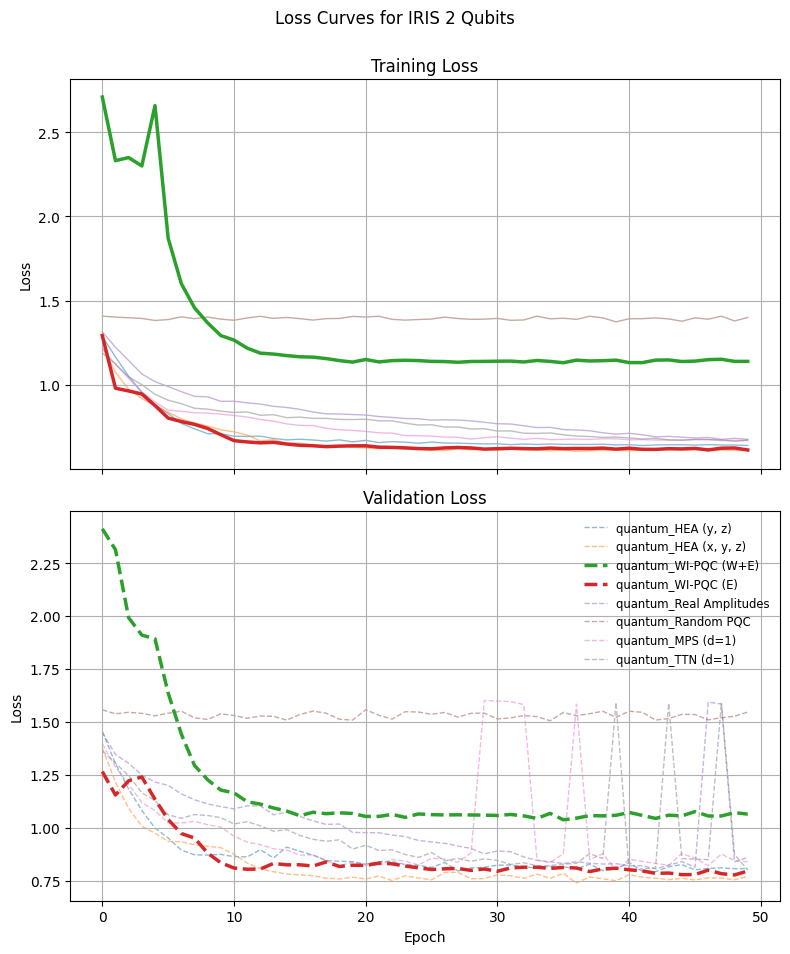

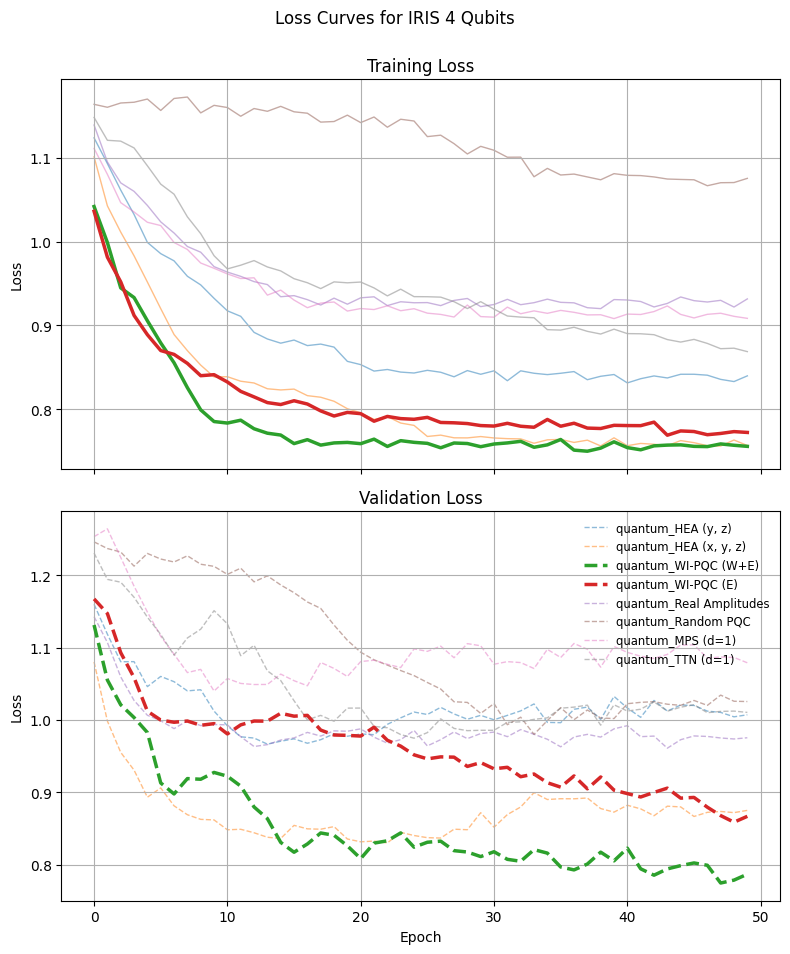

In [ ]:
import ast
import matplotlib.pyplot as plt

def plot_loss_results_vertical(dataset_df, highlight_keyword='wi-pqc'):
    def safe_eval(x):
        if isinstance(x, list): return x
        if isinstance(x, str):  return ast.literal_eval(x)
        raise ValueError(f"Cannot parse losses of type {type(x)}")

    df = dataset_df.copy()
    df['train_losses'] = df['train_losses'].apply(safe_eval)
    df['val_losses']   = df['val_losses'].apply(safe_eval)

    fig, (ax_train, ax_val) = plt.subplots(2, 1, figsize=(8, 10), sharex=True)

    for _, row in df.iterrows():
        name        = row['model_type']
        is_hi       = highlight_keyword.lower() in name.lower()
        lw, alpha   = (2.5, 1.0) if is_hi else (1.0, 0.5)
        zorder      = 2 if is_hi else 1

        ax_train.plot(row['train_losses'], label=name,
                      linewidth=lw, alpha=alpha, zorder=zorder)
        ax_val.plot(  row['val_losses'],   label=name,
                      linewidth=lw, alpha=alpha, linestyle='--', zorder=zorder)

    ax_train.set(title="Training Loss", ylabel="Loss")
    ax_val.set(  title="Validation Loss", xlabel="Epoch", ylabel="Loss")
    ax_train.grid(True)
    ax_val.grid(True)

    # Put legend inside the validation plot, upper right corner
    handles, labels = ax_val.get_legend_handles_labels()
    ax_val.legend(
        handles, labels,
        loc='upper right',
        bbox_to_anchor=(1.0, 1.0),
        borderaxespad=0.5,
        frameon=False,
        fontsize='small'
    )

    fig.suptitle(f"Loss Curves for {df['dataset_name'].iloc[0].upper()} {df['input_dim'].iloc[0]} Qubits", y=0.95)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

plot_loss_results_vertical(iris_results_2q, highlight_keyword='wi-pqc')
plot_loss_results_vertical(iris_results_4q, highlight_keyword='wi-pqc')

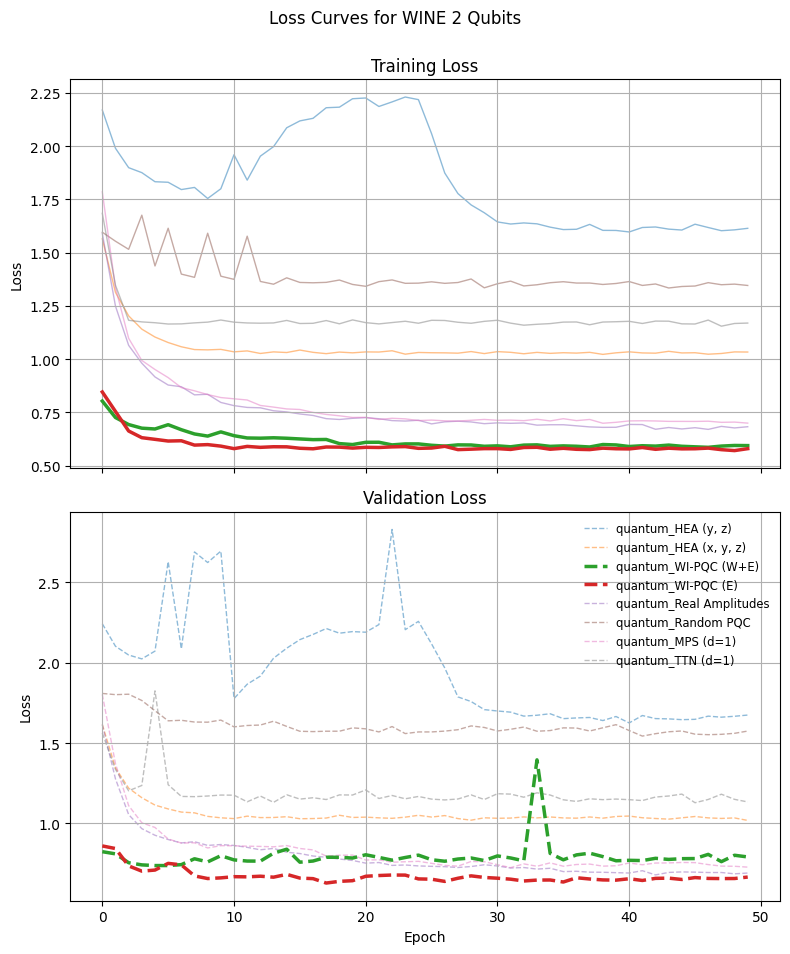

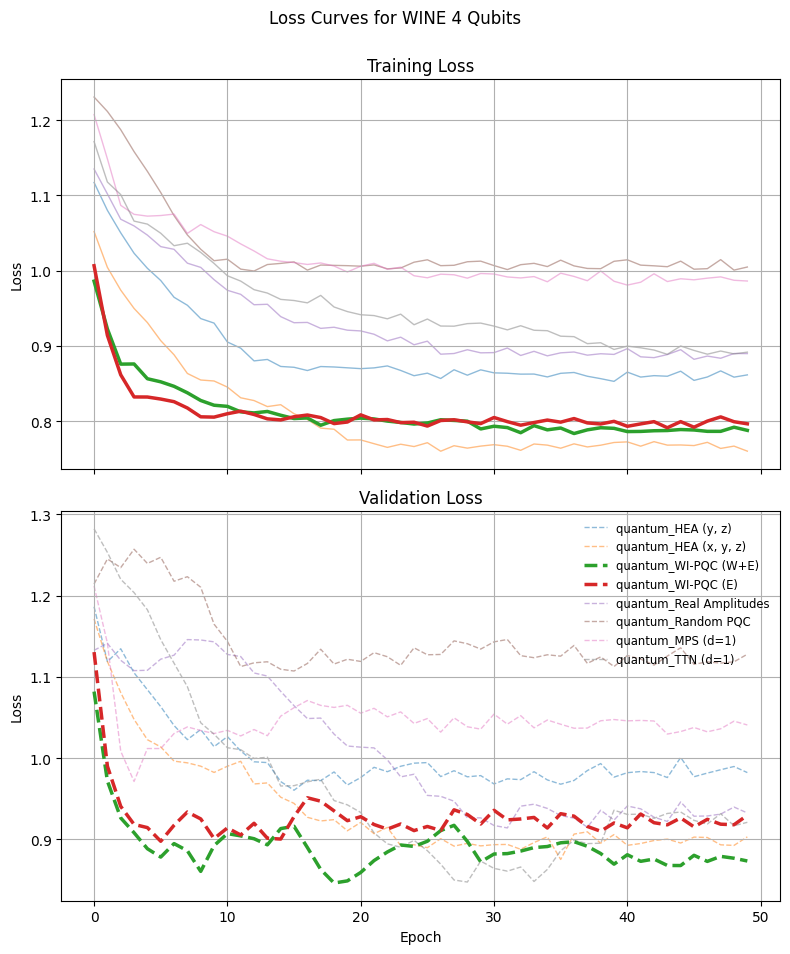

In [ ]:
plot_loss_results_vertical(wine_results_2q, highlight_keyword='wi-pqc')
plot_loss_results_vertical(wine_results_4q, highlight_keyword='wi-pqc')

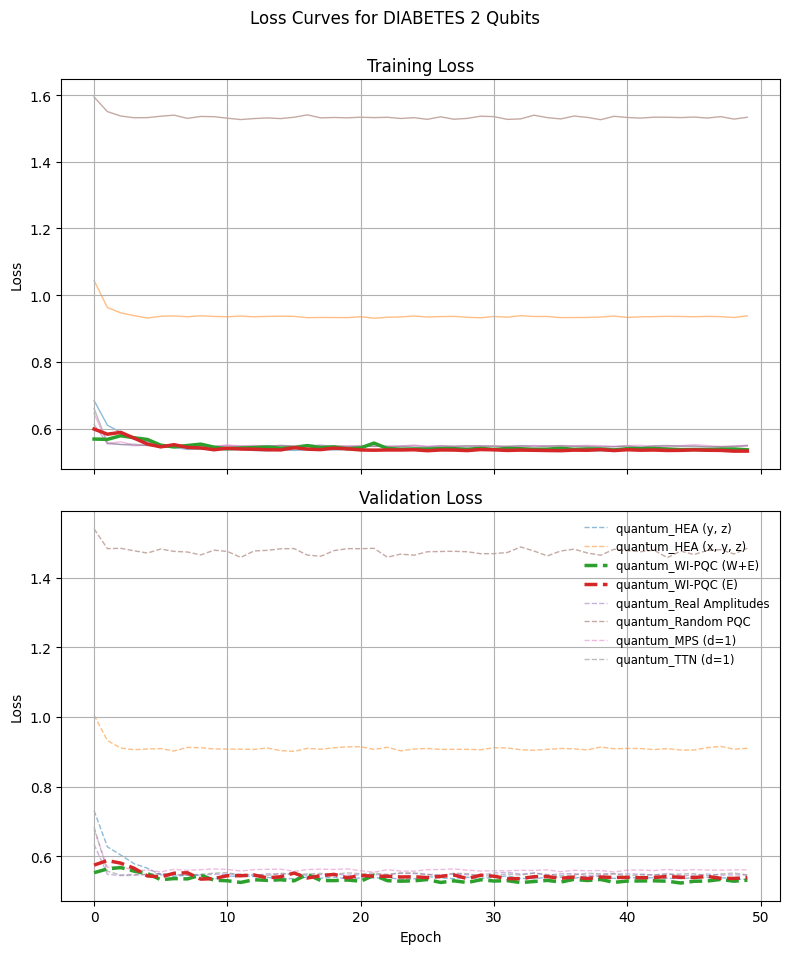

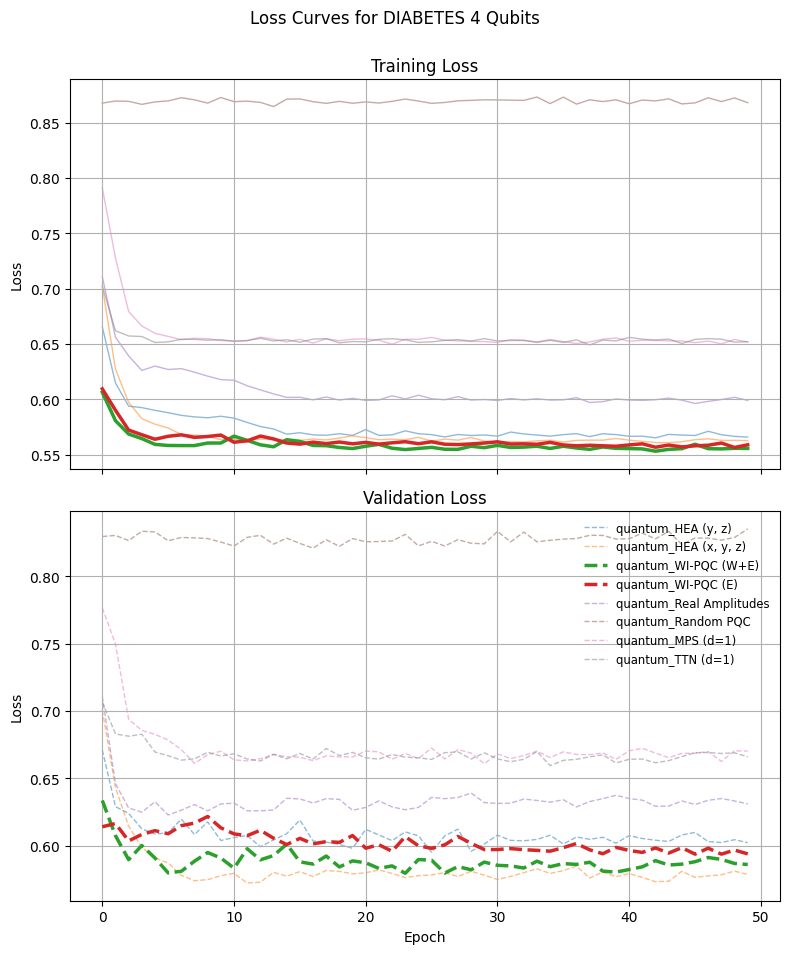

In [ ]:
plot_loss_results_vertical(diabetes_results_2q, highlight_keyword='wi-pqc')
plot_loss_results_vertical(diabetes_results_4q, highlight_keyword='wi-pqc')

In [ ]:
# from utils.nn.ClassicalNN import ClassicalNN

# model_c = ClassicalNN(input_dim, hidden_dim=input_dim, output_dim=output_dim)
# optimizer_c = optim.Adam(model_c.parameters(), lr=0.01)

# start_time = time.time()
# model_c.fit(train_loader_c, val_loader_c, epochs=epochs_c, optimizer=optimizer_c, verbose=False)
# end_time = time.time()
# average_time_per_epoch = (end_time - start_time) / epochs_c


# test_metrics = model_c.evaluate(test_loader_c)
# print(f"Test Results: Loss={test_metrics[0]:.4f}, Acc={test_metrics[1]:.4f}, F1={test_metrics[4]:.4f}")

# model_c.plot_history()

# test_loader_c_x = test_loader_c.dataset.tensors[0].numpy()
# plot_classification_results(
#     test_loader_c_x,
#     test_metrics[6],
#     test_metrics[5]
# )

In [ ]:
# from utils.ansatze.WIPQC import WeightInformedPQCAnsatz

# wi_ansatz = WeightInformedPQCAnsatz(classical_model=model_c, angle_scale_factor=0.1)
# wi_ansatz.draw()

     ┌───┐ H ┌──────────────────┐┌──────────────────┐┌──────────────────┐ Rot1.1       Ent1 ┌──────────────────┐ ┌──────────────────┐ ┌──────────────────┐ Rot1.2 ┌───────────────────┐┌───────────────────┐┌───────────────────┐ Rot2.1       Ent2 ┌───────────────────┐┌───────────────────┐┌───────────────────┐ Rot2.2 
q_0: ┤ H ├─░─┤ Rz(q0_rz_1.1_p0) ├┤ Ry(q0_ry_1.1_p1) ├┤ Rx(q0_rx_1.1_p2) ├───░──────■────░───┤ Rz(q0_rz_1.2_p6) ├─┤ Ry(q0_ry_1.2_p7) ├─┤ Rx(q0_rx_1.2_p8) ├───░────┤ Rz(q0_rz_2.1_p12) ├┤ Ry(q0_ry_2.1_p13) ├┤ Rx(q0_rx_2.1_p14) ├───░──────■────░───┤ Rz(q0_rz_2.2_p18) ├┤ Ry(q0_ry_2.2_p19) ├┤ Rx(q0_rx_2.2_p20) ├───░────
     ├───┤ ░ ├──────────────────┤├──────────────────┤├──────────────────┤   ░    ┌─┴─┐  ░   ├──────────────────┤┌┴──────────────────┤┌┴──────────────────┤   ░    ├───────────────────┤├───────────────────┤├───────────────────┤   ░    ┌─┴─┐  ░   ├───────────────────┤├───────────────────┤├───────────────────┤   ░    
q_1: ┤ H ├─░─┤ Rz(q1_rz_1.1_p3) ├┤ Ry(q1_ry_1.1_p4) 

In [ ]:
# from utils.nn.QuantumNN import QuantumNN
# from utils.ansatze.HEA import HEA

# hea_ansatz = HEA(n_qubits=input_dim, depth=2)
# model_hea = QuantumNN(ansatz=hea_ansatz.get_ansatz(), n_qubits=input_dim, num_classes=output_dim)

# hea_ansatz.draw()

     ┌──────────┐┌──────────┐                    ┌──────────┐┌───────────┐                                         ┌───────────┐┌───────────┐                          
q_0: ┤ Ry(θ[0]) ├┤ Rz(θ[4]) ├──■────■─────────■──┤ Ry(θ[8]) ├┤ Rz(θ[12]) ├───────────────────■────────■─────────■──┤ Ry(θ[16]) ├┤ Rz(θ[20]) ├──────────────────────────
     ├──────────┤├──────────┤┌─┴─┐  │         │  └──────────┘└┬──────────┤┌───────────┐    ┌─┴─┐      │         │  └───────────┘├───────────┤┌───────────┐             
q_1: ┤ Ry(θ[1]) ├┤ Rz(θ[5]) ├┤ X ├──┼────■────┼───────■───────┤ Ry(θ[9]) ├┤ Rz(θ[13]) ├────┤ X ├──────┼────■────┼────────■──────┤ Ry(θ[17]) ├┤ Rz(θ[21]) ├─────────────
     ├──────────┤├──────────┤└───┘┌─┴─┐┌─┴─┐  │       │       └──────────┘├───────────┤┌───┴───┴───┐┌─┴─┐┌─┴─┐  │        │      └───────────┘├───────────┤┌───────────┐
q_2: ┤ Ry(θ[2]) ├┤ Rz(θ[6]) ├─────┤ X ├┤ X ├──┼───────┼────────────■──────┤ Ry(θ[10]) ├┤ Rz(θ[14]) ├┤ X ├┤ X ├──┼────────┼────────────■──────┤ Ry(θ[18]) ├┤ Rz(θ

In [ ]:
# from utils.ansatze.MPS import MPSAnsatz
# from utils.ansatze.TTN import TTNAnsatz

# mps_ansatz = MPSAnsatz(n_qubits=input_dim)
# mps_ansatz.draw()

# ttn_ansatz = TTNAnsatz(n_qubits=input_dim)
# ttn_ansatz.draw()


# model_mps = QuantumNN(ansatz=mps_ansatz.get_ansatz(), n_qubits=input_dim, num_classes=output_dim)
# model_ttn = QuantumNN(ansatz=ttn_ansatz.get_ansatz(), n_qubits=input_dim, num_classes=output_dim)


# circuit_fp, params_fp = AnsatzExtractor.extract_and_store_model_schema(ttn_ansatz, model_ttn, ".")
# qc, metadata = AnsatzExtractor.load_ansatz_from_model_schema(circuit_fp, params_fp)


ParameterView([ParameterVectorElement(θ_0_1[0]), ParameterVectorElement(θ_0_1[1]), ParameterVectorElement(θ_0_1[2]), ParameterVectorElement(θ_0_1[3]), ParameterVectorElement(θ_0_1[4]), ParameterVectorElement(θ_0_1[5]), ParameterVectorElement(θ_0_1[6]), ParameterVectorElement(θ_0_1[7]), ParameterVectorElement(θ_1_2[0]), ParameterVectorElement(θ_1_2[1]), ParameterVectorElement(θ_1_2[2]), ParameterVectorElement(θ_1_2[3]), ParameterVectorElement(θ_1_2[4]), ParameterVectorElement(θ_1_2[5]), ParameterVectorElement(θ_1_2[6]), ParameterVectorElement(θ_1_2[7]), ParameterVectorElement(θ_2_3[0]), ParameterVectorElement(θ_2_3[1]), ParameterVectorElement(θ_2_3[2]), ParameterVectorElement(θ_2_3[3]), ParameterVectorElement(θ_2_3[4]), ParameterVectorElement(θ_2_3[5]), ParameterVectorElement(θ_2_3[6]), ParameterVectorElement(θ_2_3[7])])
     ┌──────────────┐     ┌──────────────┐     ┌──────────────┐     ┌──────────────┐ ░                                                                                 ░

In [ ]:
qc.decompose().draw(fold=-1)

┌──────────────┐     ┌──────────────┐     ┌──────────────┐     ┌──────────────┐ ░                                                                                 ░ 
q_0: ┤ Ry(θ_0_1[0]) ├──■──┤ Ry(θ_0_1[2]) ├──■──┤ Ry(θ_0_1[4]) ├──■──┤ Ry(θ_0_1[6]) ├─░─────────────────────────────────────────────────────────────────────────────────░─
     ├──────────────┤┌─┴─┐├──────────────┤┌─┴─┐├──────────────┤┌─┴─┐├──────────────┤ ░ ┌──────────────┐     ┌──────────────┐     ┌──────────────┐     ┌──────────────┐ ░ 
q_1: ┤ Ry(θ_0_1[1]) ├┤ X ├┤ Ry(θ_0_1[3]) ├┤ X ├┤ Ry(θ_0_1[5]) ├┤ X ├┤ Ry(θ_0_1[7]) ├─░─┤ Ry(θ_1_3[0]) ├──■──┤ Ry(θ_1_3[2]) ├──■──┤ Ry(θ_1_3[4]) ├──■──┤ Ry(θ_1_3[6]) ├─░─
     ├──────────────┤└───┘├──────────────┤└───┘├──────────────┤└───┘├──────────────┤ ░ └──────────────┘  │  └──────────────┘  │  └──────────────┘  │  └──────────────┘ ░ 
q_2: ┤ Ry(θ_2_3[0]) ├──■──┤ Ry(θ_2_3[2]) ├──■──┤ Ry(θ_2_3[4]) ├──■──┤ Ry(θ_2_3[6]) ├─░───────────────────┼────────────────────┼────────────────────┼───────────────────░─
     ├──────────────┤┌─┴─┐├──────────────┤┌─┴─┐├──────────────┤┌─┴─┐├──────────────┤ ░ ┌──────────────┐┌─┴─┐┌──────────────┐┌─┴─┐┌──────────────┐┌─┴─┐┌──────────────┐ ░ 
q_3: ┤ Ry(θ_2_3[1]) ├┤ X ├┤ Ry(θ_2_3[3]) ├┤ X ├┤ Ry(θ_2_3[5]) ├┤ X ├┤ Ry(θ_2_3[7]) ├─░─┤ Ry(θ_1_3[1]) ├┤ X ├┤ Ry(θ_1_3[3]) ├┤ X ├┤ Ry(θ_1_3[5]) ├┤ X ├┤ Ry(θ_1_3[7]) ├─░─
     └──────────────┘└───┘└──────────────┘└───┘└──────────────┘└───┘└──────────────┘ ░ └──────────────┘└───┘└──────────────┘└───┘└──────────────┘└───┘└──────────────┘ ░

In [ ]:
# model_hea = QuantumNN(ansatz=hea_ansatz.get_ansatz(), n_qubits=input_dim, num_classes=output_dim)

# optimizer_q = optim.Adam(model_hea.parameters(), lr=0.05)
# scheduler_q = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer_q,
#     mode      = "min",       
#     factor    = 0.3,          
#     patience  = epochs_q//5,       
#     min_lr    = 1e-4,        
#     verbose   = True,
# )

# start_time = time.time()
# model_hea.fit(train_loader_q, val_loader_q, epochs=epochs_q, optimizer=optimizer_q, scheduler=scheduler_q)
# end_time = time.time()  

# test_metrics_hea = model_hea.evaluate(test_loader_q)
# print(f"Test Results: Loss={test_metrics_hea[0]:.4f}, Acc={test_metrics_hea[1]:.4f}, F1={test_metrics_hea[4]:.4f}")

# model_hea.plot_history()

# test_loader_q_x = test_loader_q.dataset.tensors[0].numpy()
# plot_classification_results(
#     test_loader_q_x,
#     test_metrics_hea[6],
#     test_metrics_hea[5]
# )

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:59: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/3 [00:00<?, ?it/s]

KeyboardInterrupt: 

/var/folders/dv/57s4jp9x1h1509smqvyknt5h0000gn/T/ipykernel_40545/2411793694.py:34: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler(options={"shots": 1024}) # shots-based simulation (approximate, fast, but introduces sampling noise)
/var/folders/dv/57s4jp9x1h1509smqvyknt5h0000gn/T/ipykernel_40545/2411793694.py:35: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  gradient = ParamShiftSamplerGradient(sampler) # for param shift rule (exact, slow)
/var/folders/dv/57s4jp9x1h1509smqvyknt5h0000gn/T/ipykernel_40545/241179

Test Results: Loss=0.7998, Acc=0.6667, F1=0.6366


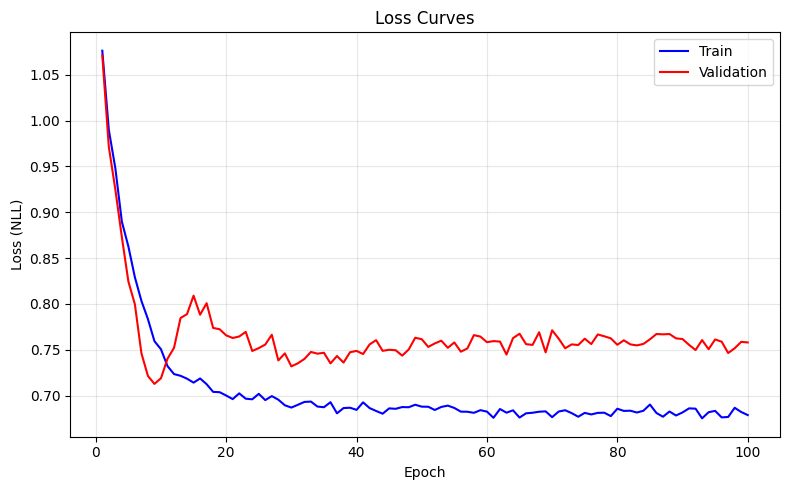

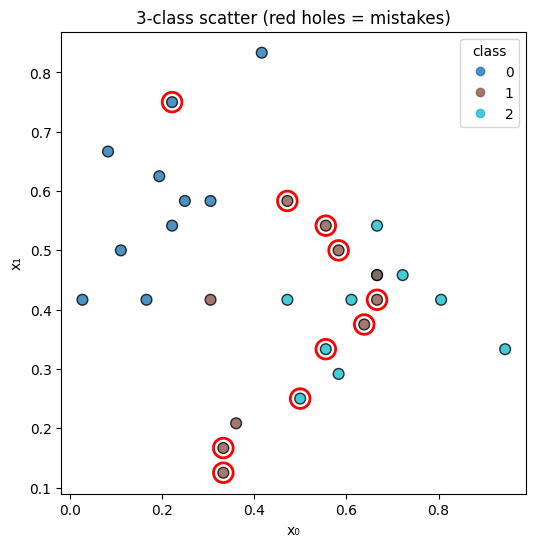

In [ ]:
# model_wi = QuantumNN(
#     ansatz=wi_ansatz.get_ansatz(),
#     initial_point=wi_ansatz.get_initial_point(),
#     n_qubits=input_dim,
#     num_classes=output_dim
# )

# optimizer_q = optim.Adam(model_wi.parameters(), lr=0.05)
# scheduler_q = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer_q,
#     mode      = "min",       
#     factor    = 0.3,          
#     patience  = epochs_q//5,       
#     min_lr    = 1e-4,        
#     verbose   = True,
# )

# start_time = time.time()
# model_wi.fit(train_loader_q, val_loader_q, epochs=epochs_q, optimizer=optimizer_q, scheduler=scheduler_q)
# end_time = time.time()  

# test_metrics_wi = model_wi.evaluate(test_loader_q)
# print(f"Test Results: Loss={test_metrics_wi[0]:.4f}, Acc={test_metrics_wi[1]:.4f}, F1={test_metrics_wi[4]:.4f}")

# model_wi.plot_history()

# test_loader_q_x = test_loader_q.dataset.tensors[0].numpy()

# plot_classification_results(
#     test_loader_q_x,
#     test_metrics_wi[6],
#     test_metrics_wi[5]
# )

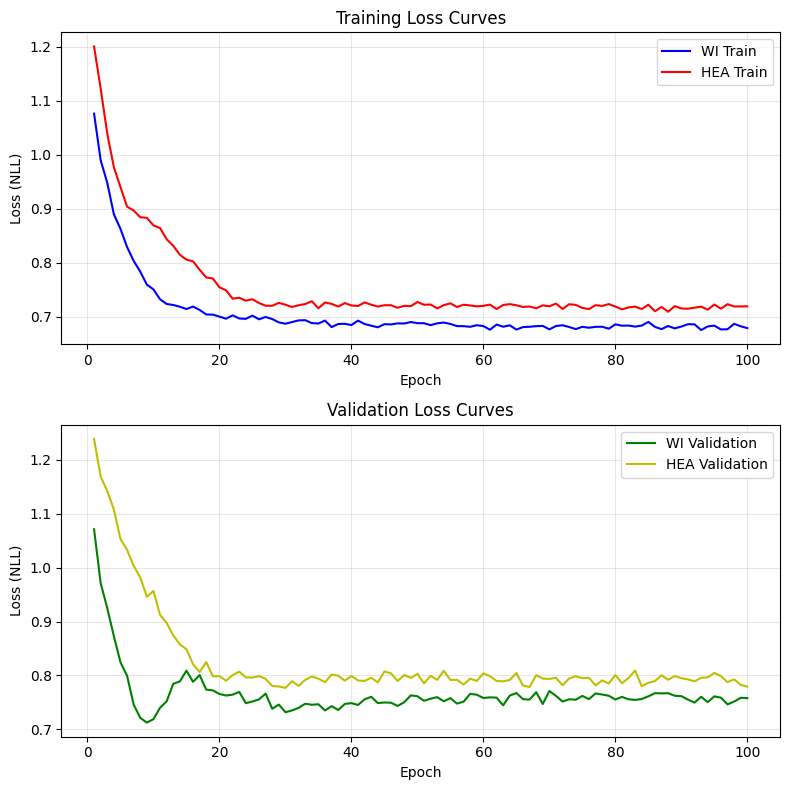

In [ ]:
# # plot test_metrics_wi and test_metrics_hea

# wi_train_loss = model_wi.history["train_loss"]
# wi_val_loss = model_wi.history["val_loss"]

# hea_train_loss = model_hea.history["train_loss"]
# hea_val_loss = model_hea.history["val_loss"]

# fig, ax = plt.subplots(2, 1, figsize=(8, 8))  # 2 rows, 1 column

# epochs = range(1, len(wi_train_loss) + 1)

# # WI loss curves
# ax[0].plot(epochs, wi_train_loss, 'b-', label="WI Train")
# ax[0].plot(epochs, hea_train_loss, 'r-', label="HEA Train")
# ax[0].set_xlabel("Epoch")
# ax[0].set_ylabel("Loss (NLL)")
# ax[0].set_title("Training Loss Curves")
# ax[0].legend()
# ax[0].grid(alpha=0.3)

# # HEA loss curves
# ax[1].plot(epochs, wi_val_loss, 'g-', label="WI Validation")
# ax[1].plot(epochs, hea_val_loss, 'y-', label="HEA Validation")
# ax[1].set_xlabel("Epoch")
# ax[1].set_ylabel("Loss (NLL)")
# ax[1].set_title("Validation Loss Curves")
# ax[1].legend()
# ax[1].grid(alpha=0.3)

# plt.tight_layout()
# plt.show()
